In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1 Physical GPUs, 1 Logical GPUs


**First we'll be importing all the necessary libraries**

In [3]:
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Reading the datasets from the directory**

In [4]:
data = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
data.head(20)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg
9,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",10_right.jpg


**Information Extraction from keywords given to the patients after diagnosed**

In [5]:
def has_condn(term,text):
    if term in text:
        return 1
    else:
        return 0

In [6]:


#data[data.O==1].head(20)  #drusen or epiretinal membrane

def process_dataset(data):
    #create 2 more columns labelling them whether right or left cataract
    data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    
    data["LD"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))
    data["RD"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    
    data["LH"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))
    data["RH"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))

    data["LM"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    data["RM"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    
    data["LA"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    data["RA"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    
    data["LO"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    data["RO"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    
    #store the right/left cataract images ids in a array
    left_cataract_images = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values
    
    #store the left/right normal image ids in a array
    left_normal = data.loc[(data.C == 0) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(350,random_state=42).values
    right_normal = data.loc[(data.C == 0) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(350,random_state=42).values
    
    #store the left/right diabetes image ids
    left_diab = data.loc[(data.C == 0) & (data.LD == 1)]["Left-Fundus"].values
    right_diab = data.loc[(data.C == 0) & (data.RD == 1)]["Right-Fundus"].values 

    #store the left/right glaucoma image ids
    left_glaucoma = data.loc[(data.C == 0) & (data.LG == 1)]["Left-Fundus"].values
    right_glaucoma = data.loc[(data.C == 0) & (data.RG == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_hyper = data.loc[(data.C == 0) & (data.LH == 1)]["Left-Fundus"].values
    right_hyper = data.loc[(data.C == 0) & (data.RH == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_myopia = data.loc[(data.C == 0) & (data.LM == 1)]["Left-Fundus"].values
    right_myopia = data.loc[(data.C == 0) & (data.RM == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_age = data.loc[(data.C == 0) & (data.LA == 1)]["Left-Fundus"].values
    right_age = data.loc[(data.C == 0) & (data.RA == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_other = data.loc[(data.C == 0) & (data.LO == 1)]["Left-Fundus"].values
    right_other = data.loc[(data.C == 0) & (data.RO == 1)]["Right-Fundus"].values 
    
    normalones = np.concatenate((left_normal,right_normal),axis = 0);
    cataractones = np.concatenate((left_cataract_images,right_cataract_images),axis = 0);
    diabones = np.concatenate((left_diab,right_diab),axis = 0);
    glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis = 0);
    hyper = np.concatenate((left_hyper,right_hyper),axis = 0);
    myopia = np.concatenate((left_myopia,right_myopia),axis = 0);
    age = np.concatenate((left_age,right_age),axis=0);
    other = np.concatenate((left_other,right_other),axis = 0);
    
    return normalones,cataractones,diabones,glaucoma,hyper,myopia,age,other;

Attaching labels based whether cataract is present on which eye (left/right)

In [7]:
normal , cataract , diab, glaucoma , hyper , myopia , age, other = process_dataset(data);

print("Dataset stats::")
print("Normal ::" , len(normal))
print("Cataract ::" , len(cataract))
print("Diabetes ::" , len(diab))
print("Glaucoma ::" , len(glaucoma))
print("Hypertension ::" , len(hyper))
print("Myopia ::" , len(myopia))
print("Age Issues ::" , len(age))
print("Other ::" , len(other))
print("*"*50)
print("Normal::\n")
print(normal)
print("*"*50)
print("*"*50)
print("Cataract::\n")
print(cataract)
print("*"*50)
print("*"*50)
print("Diabetes::\n")
print(diab)
print("*"*50)
print("*"*50)
print("Glaucoma::\n")
print(glaucoma)
print("*"*50)
print("*"*50)
print("HyperTension::\n")
print(hyper)
print("*"*50)
print("*"*50)
print("Myopia::\n")
print(myopia)
print("*"*50)
print("*"*50)
print("Age Related::\n")
print(age)
print("*"*50)
print("*"*50)
print("Other ::\n")
print(other)
print("*"*50)

Dataset stats::
Normal :: 700
Cataract :: 594
Diabetes :: 1818
Glaucoma :: 610
Hypertension :: 374
Myopia :: 479
Age Issues :: 551
Other :: 324
**************************************************
Normal::

['3332_left.jpg' '4059_left.jpg' '69_left.jpg' '2415_left.jpg'
 '4176_left.jpg' '2711_left.jpg' '4614_left.jpg' '3174_left.jpg'
 '2862_left.jpg' '2424_left.jpg' '3193_left.jpg' '3306_left.jpg'
 '2961_left.jpg' '2425_left.jpg' '2858_left.jpg' '3180_left.jpg'
 '2668_left.jpg' '2659_left.jpg' '2336_left.jpg' '277_left.jpg'
 '2897_left.jpg' '1151_left.jpg' '3011_left.jpg' '3083_left.jpg'
 '4059_left.jpg' '4576_left.jpg' '2563_left.jpg' '2549_left.jpg'
 '3025_left.jpg' '2330_left.jpg' '2562_left.jpg' '3438_left.jpg'
 '3047_left.jpg' '3150_left.jpg' '570_left.jpg' '2430_left.jpg'
 '2532_left.jpg' '3426_left.jpg' '2475_left.jpg' '3214_left.jpg'
 '1253_left.jpg' '2819_left.jpg' '3415_left.jpg' '2973_left.jpg'
 '2488_left.jpg' '2349_left.jpg' '3025_left.jpg' '3125_left.jpg'
 '160_left.jpg' '29

Now since we have segregated the images to N and C labels <br>
We need to create a Dataset for VGG19 where it will do the image extraction and then assign the label<br>

In [8]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images"
image_size=224
labels = []
dataset = []
def dataset_generator(imagecategory , label):
    for img in tqdm(imagecategory):
        #image category here would be either normal or cataract
        imgpath = os.path.join(dataset_dir,img);
        
        #now we try to read the image and resize it accordingly
        try:
            image = cv2.imread(imgpath,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue;
        dataset.append([np.array(image),np.array(label)]);
    random.shuffle(dataset);
    
    return dataset;

Generating Dataset

In [9]:
# Normal == 0
# Cataract == 1
# Diabetes == 2
# Glaucoma == 3
# HyperTension == 4
# Myopia == 5
# Age == 6
# Other == 7

dataset = dataset_generator(normal,0)
dataset = dataset_generator(cataract,1)
dataset = dataset_generator(diab,2)
dataset = dataset_generator(glaucoma,3)
dataset = dataset_generator(hyper,4)
dataset = dataset_generator(myopia,5)
dataset = dataset_generator(age,6)
dataset = dataset_generator(other,7)

len(dataset)


 24%|██▍       | 142/594 [00:01<00:05, 89.08it/s][ WARN:0@32.866] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2244_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@32.899] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2251_left.jpg'): can't open/read file: check file path/integrity
  0%|          | 0/1818 [00:00<?, ?it/s][ WARN:0@35.943] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@36.011] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/50_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@36.027] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/74_lef

5396

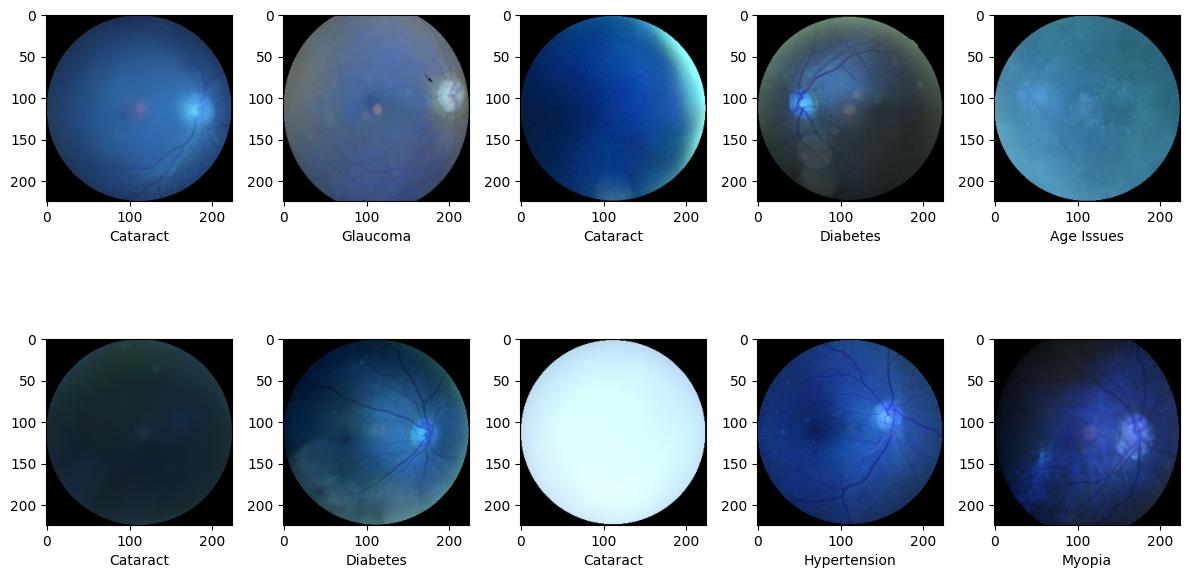

In [10]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"
           
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

# **Kfold**

In [11]:
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split


train_x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3);
train_y = np.array([i[1] for i in dataset])
#splitting the dataset
x_train , x_test , y_train, y_test = train_test_split(train_x,train_y, test_size=0.2)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define variables to track the best model
best_model = None
best_score = 0.0

# Evaluate the model
scores = []
for train_index, test_index in kfold.split(train_x):
    # Get the training and testing data for this fold
    X_train, X_test = train_x[train_index], train_x[test_index]
    y_train = to_categorical(train_y[train_index], num_classes=8)
    y_test = to_categorical(train_y[test_index], num_classes=8)


# **Focal loss**

In [12]:
import tensorflow as tf
import numpy as np
def focal_loss(y_true, y_pred, alpha=1, gamma=2):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)  # Clip values to avoid numerical instability
    focal_loss = -alpha * (1 - y_pred) ** gamma * y_true * tf.math.log(y_pred)
    return tf.reduce_mean(focal_loss)


# **Creating the Model**

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [14]:
base_model = MobileNetV2(weights='imagenet', include_top=False)

9406464/9406464 [==============================] - 0s 0us/step


In [16]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def get_model(model):

    # Create the final model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    predictions = Dense(8, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
        # Specify the optimizer (e.g., Adam) and learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    # Choose an appropriate loss function (e.g., categorical_crossentropy for multiclass classification)
    loss = 'categorical_crossentropy'

    # Compile the model with metrics (e.g., accuracy)
    model.compile(optimizer=optimizer,
                  loss=lambda y_true, y_pred: focal_loss(y_true, y_pred), 
                  metrics=['accuracy'])
    
    return model


Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 6.7585 - accuracy: 0.2440
Epoch 1: val_accuracy improved from -inf to 0.15833, saving model to MobileNetV2.h5
68/68 [==============================] - 50s 200ms/step - loss: 6.7585 - accuracy: 0.2440 - val_loss: 6.0818 - val_accuracy: 0.1583
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 5.4857 - accuracy: 0.3661
Epoch 2: val_accuracy did not improve from 0.15833
68/68 [==============================] - 11s 156ms/step - loss: 5.4857 - accuracy: 0.3661 - val_loss: 4.9612 - val_accuracy: 0.1389
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 4.4443 - accuracy: 0.4228
Epoch 3: val_accuracy did not improve from 0.15833
68/68 [==============================] - 11s 156ms/step - loss: 4.4443 - accuracy: 0.4228 - val_loss: 4.0761 - val_accuracy: 0.1083
Epoch 4/100
68/68 [==============================] - ETA: 0s - loss: 3.6032 - accuracy: 0.4789
Epoch 4: val_accuracy did not improve 

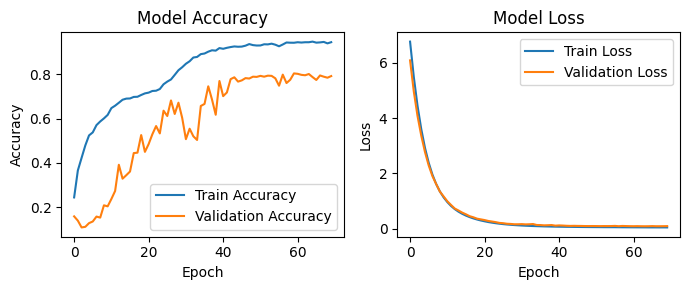

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 6.8710 - accuracy: 0.4427
Epoch 1: val_accuracy improved from 0.80463 to 0.88230, saving model to MobileNetV2.h5
68/68 [==============================] - 39s 198ms/step - loss: 6.8710 - accuracy: 0.4427 - val_loss: 6.2361 - val_accuracy: 0.8823
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 5.7404 - accuracy: 0.6560
Epoch 2: val_accuracy improved from 0.88230 to 0.94161, saving model to MobileNetV2.h5
68/68 [==============================] - 11s 162ms/step - loss: 5.7404 - accuracy: 0.6560 - val_loss: 5.1834 - val_accuracy: 0.9416
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 4.7660 - accuracy: 0.7464
Epoch 3: val_accuracy did not improve from 0.94161
68/68 [==============================] - 11s 155ms/step - loss: 4.7660 - accuracy: 0.7464 - val_loss: 4.3046 - val_accuracy: 0.8925
Epoch 4/100
68/68 [==============================] - ETA: 0s - loss: 3.9402 - accuracy: 0.8087

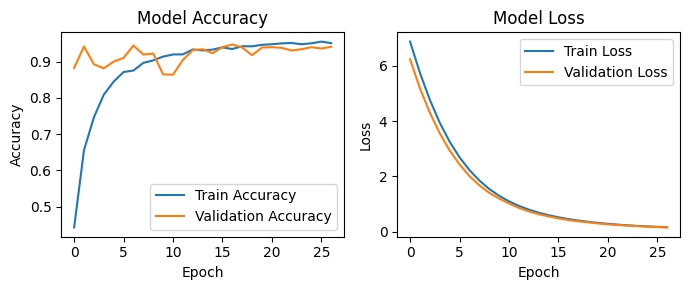

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 6.9033 - accuracy: 0.4885
Epoch 1: val_accuracy did not improve from 0.94717
68/68 [==============================] - 38s 172ms/step - loss: 6.9033 - accuracy: 0.4885 - val_loss: 6.2757 - val_accuracy: 0.8703
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 5.8092 - accuracy: 0.6792
Epoch 2: val_accuracy did not improve from 0.94717
68/68 [==============================] - 11s 155ms/step - loss: 5.8092 - accuracy: 0.6792 - val_loss: 5.2811 - val_accuracy: 0.9064
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 4.8674 - accuracy: 0.7375
Epoch 3: val_accuracy did not improve from 0.94717
68/68 [==============================] - 11s 156ms/step - loss: 4.8674 - accuracy: 0.7375 - val_loss: 4.4072 - val_accuracy: 0.9453
Epoch 4/100
68/68 [==============================] - ETA: 0s - loss: 4.0552 - accuracy: 0.7957
Epoch 4: val_accuracy improved from 0.94717 to 0.95181, saving model to

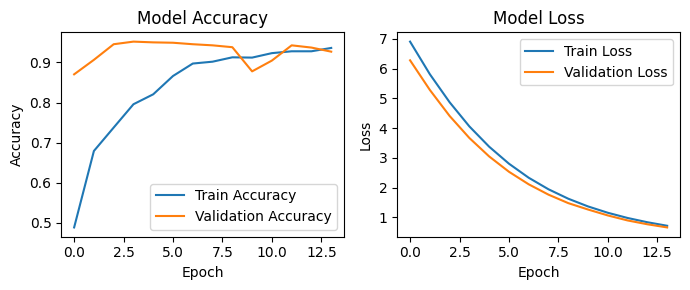

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 6.8444 - accuracy: 0.4827
Epoch 1: val_accuracy did not improve from 0.95181
68/68 [==============================] - 38s 172ms/step - loss: 6.8444 - accuracy: 0.4827 - val_loss: 6.2133 - val_accuracy: 0.7720
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 5.6991 - accuracy: 0.7271
Epoch 2: val_accuracy did not improve from 0.95181
68/68 [==============================] - 11s 155ms/step - loss: 5.6991 - accuracy: 0.7271 - val_loss: 5.1644 - val_accuracy: 0.8619
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 4.7263 - accuracy: 0.8038
Epoch 3: val_accuracy did not improve from 0.95181
68/68 [==============================] - 11s 155ms/step - loss: 4.7263 - accuracy: 0.8038 - val_loss: 4.2667 - val_accuracy: 0.9101
Epoch 4/100
68/68 [==============================] - ETA: 0s - loss: 3.9089 - accuracy: 0.8513
Epoch 4: val_accuracy did not improve from 0.95181
68/68 [=============

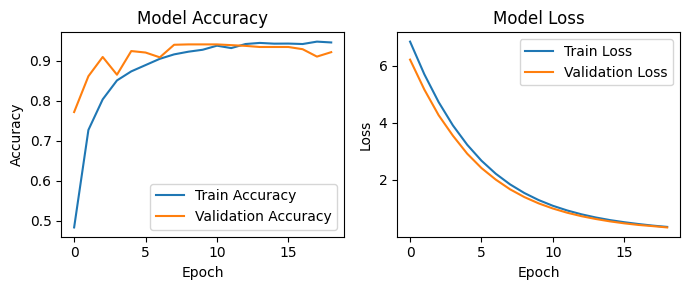

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 6.8666 - accuracy: 0.4772
Epoch 1: val_accuracy did not improve from 0.95181
68/68 [==============================] - 37s 172ms/step - loss: 6.8666 - accuracy: 0.4772 - val_loss: 6.2732 - val_accuracy: 0.8313
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 5.7525 - accuracy: 0.7616
Epoch 2: val_accuracy did not improve from 0.95181
68/68 [==============================] - 11s 155ms/step - loss: 5.7525 - accuracy: 0.7616 - val_loss: 5.2229 - val_accuracy: 0.9314
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 4.8011 - accuracy: 0.8367
Epoch 3: val_accuracy did not improve from 0.95181
68/68 [==============================] - 11s 155ms/step - loss: 4.8011 - accuracy: 0.8367 - val_loss: 4.3457 - val_accuracy: 0.9435
Epoch 4/100
68/68 [==============================] - ETA: 0s - loss: 3.9915 - accuracy: 0.8599
Epoch 4: val_accuracy did not improve from 0.95181
68/68 [=============

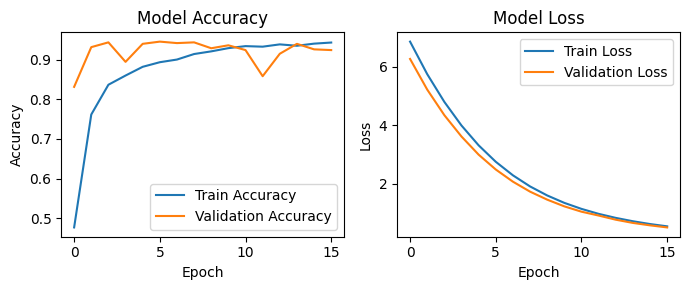

'\nbefore focal loss\nloss: 0.1081 - accuracy: 0.9534 - val_loss: 1.2569 - val_accuracy: 0.7102\n'

In [17]:

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("MobileNetV2.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,verbose=1)

from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2


train_x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3);
train_y = np.array([i[1] for i in dataset])
#splitting the dataset
x_train , x_test , y_train, y_test = train_test_split(train_x,train_y, test_size=0.2)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define variables to track the best model
best_model = None
best_score = 0.0

# Evaluate the model
scores = []
for train_index, test_index in kfold.split(train_x):
    # Get the training and testing data for this fold
    X_train, X_test = train_x[train_index], train_x[test_index]
    y_train = to_categorical(train_y[train_index], num_classes=8)
    y_test = to_categorical(train_y[test_index], num_classes=8)
    
    model=get_model(MobileNetV2)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=64,
        epochs=100,
        callbacks=[checkpoint,earlystop]

    )
    
    import matplotlib.pyplot as plt

    # Access training history
    history_dict = history.history

    # Plot training & validation accuracy values
    plt.figure(figsize=(7, 3))
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['accuracy'], label='Train Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['loss'], label='Train Loss')
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
'''
before focal loss
loss: 0.1081 - accuracy: 0.9534 - val_loss: 1.2569 - val_accuracy: 0.7102
'''

In [19]:
loss,accuracy = model.evaluate(X_test,y_test)
#print("Accuracy:",accuracy)
'''
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
'''

34/34 [==============================] - 1s 23ms/step - loss: 0.4977 - accuracy: 0.9240


'\n# Evaluate the model on the test data\ntest_loss, test_accuracy = model.evaluate(X_test)\nprint(f"Test Loss: {test_loss:.4f}")\nprint(f"Test Accuracy: {test_accuracy:.4f}")\n'

In [21]:
'''import matplotlib.pyplot as plt

# Access training history
history_dict = history.history

# Plot training & validation accuracy values
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()'''

"import matplotlib.pyplot as plt\n\n# Access training history\nhistory_dict = history.history\n\n# Plot training & validation accuracy values\nplt.figure(figsize=(7, 3))\nplt.subplot(1, 2, 1)\nplt.plot(history_dict['accuracy'], label='Train Accuracy')\nplt.plot(history_dict['val_accuracy'], label='Validation Accuracy')\nplt.title('Model Accuracy')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.legend()\n\n# Plot training & validation loss values\nplt.subplot(1, 2, 2)\nplt.plot(history_dict['loss'], label='Train Loss')\nplt.plot(history_dict['val_loss'], label='Validation Loss')\nplt.title('Model Loss')\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.legend()\n\nplt.tight_layout()\nplt.show()"

In [22]:
from sklearn.metrics import confusion_matrix, classification_report


In [23]:
y_pred = model.predict(X_test)

34/34 [==============================] - 1s 21ms/step


In [24]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [25]:
y_true_labels = np.argmax(y_test, axis=1)

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
confusion = confusion_matrix(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[130   0  19   0   0   0   0   0]
 [  0 107   0   0   0   0   0   0]
 [  0   0 335   5  17   1   0   3]
 [  0   0   4 106   3   2   9   0]
 [  0   0   2   0  56   0   0   0]
 [  0   0   6   2   0  95   1   0]
 [  0   0   0   3   2   0 105   0]
 [  0   0   2   1   0   0   0  63]]


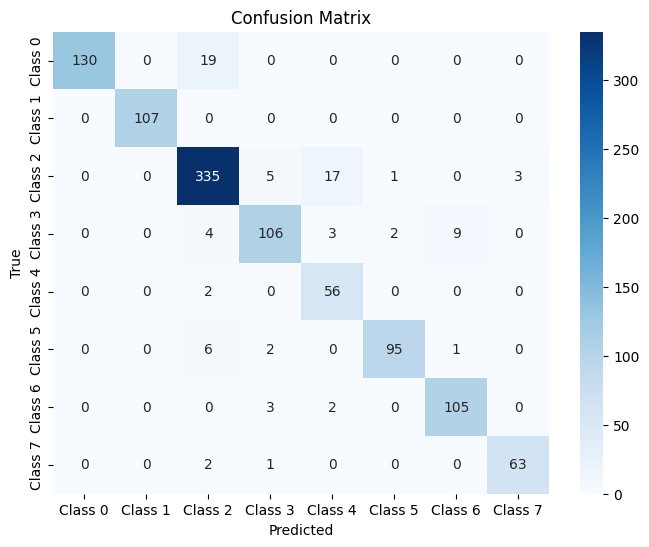

In [28]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [29]:
report = classification_report(y_true_labels, y_pred_labels)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       149
           1       1.00      1.00      1.00       107
           2       0.91      0.93      0.92       361
           3       0.91      0.85      0.88       124
           4       0.72      0.97      0.82        58
           5       0.97      0.91      0.94       104
           6       0.91      0.95      0.93       110
           7       0.95      0.95      0.95        66

    accuracy                           0.92      1079
   macro avg       0.92      0.93      0.92      1079
weighted avg       0.93      0.92      0.92      1079



In [30]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

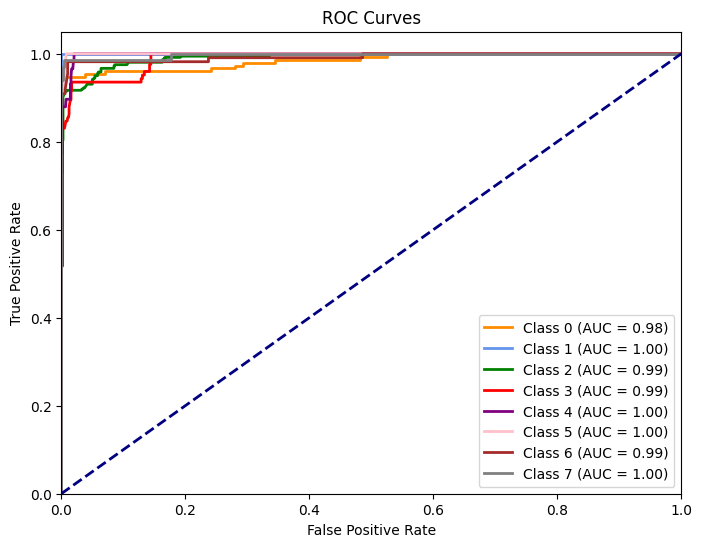

In [31]:
# Calculate ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 8  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'pink', 'brown', 'gray']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()


In [32]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

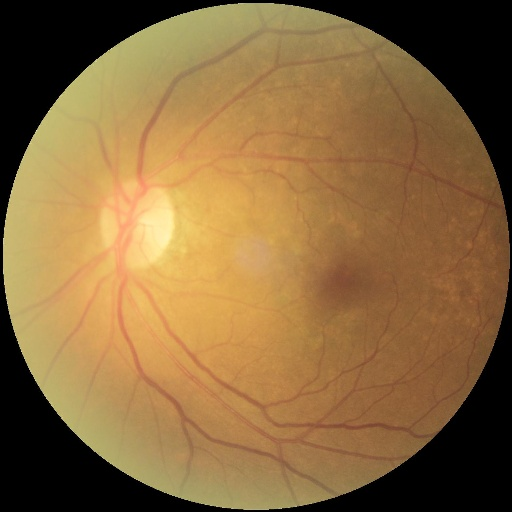

In [111]:
model_builder = keras.applications.MobileNetV2
img_size = (224, 224)
preprocess_input = keras.applications.mobilenet_v2.preprocess_input
decode_predictions = keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "out_relu"

# The local path to our target image
img_path = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/101_left.jpg"

display(Image(img_path))

In [112]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

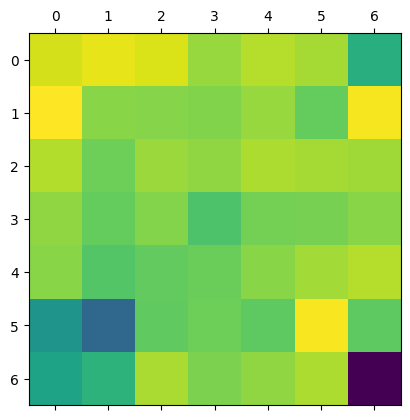

In [119]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model


model = get_model(model_builder)



# Remove last layer's softmax
model.layers[-1].activation = None

# Prepare the image

img_array = keras.applications.mobilenet_v2.preprocess_input(get_img_array(img_path, size=img_size))

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display the heatmap
plt.matshow(heatmap)
plt.show()


/tmp/ipykernel_32/2437998364.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


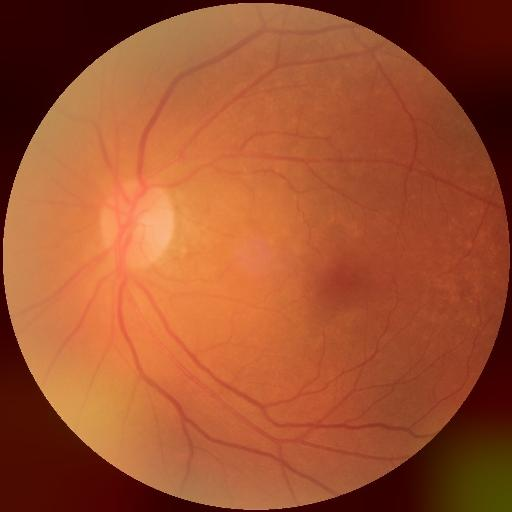

In [120]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [136]:
model.save("Mobile.h5")

In [ ]:
#############################################################################################################################

In [121]:
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50

resnet = ResNet50(weights="imagenet", input_shape=(224, 224, 3), include_top=False)

for layer in resnet.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [122]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a custom head for your model
def get_model(model):
        x = base_model.output
        x = Flatten()(x)
        x = Dropout(0.5)(x)
        x = BatchNormalization()(x)
        x = Dense(512, activation='relu')(x)  # Add a dense layer
        x = Dropout(0.5)(x)  # Add dropout for regularization
        x = BatchNormalization()(x)  # Add batch normalization

        # Add more dense layers for better feature representation
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = BatchNormalization()(x)

        # Output layer
        predictions = Dense(8, activation='softmax')(x)  # Assuming you have 8 classes
        # Create the model
        model = Model(inputs=base_model.input, outputs=predictions)
        
        # Specify the optimizer (e.g., Adam) and learning rate
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

        # Choose an appropriate loss function (e.g., categorical_crossentropy for multiclass classification)
        loss = 'categorical_crossentropy'

        # Compile the model with metrics (e.g., accuracy)
        model.compile(optimizer=optimizer,
                      loss=lambda y_true, y_pred: focal_loss(y_true, y_pred), 
                      metrics=['accuracy'])
        
        return model


In [66]:
#model.summary()

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.4284
Epoch 1: val_accuracy improved from -inf to 0.54074, saving model to Resnet50.h5
68/68 [==============================] - 19s 199ms/step - loss: 0.1694 - accuracy: 0.4284 - val_loss: 0.1423 - val_accuracy: 0.5407
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.5744
Epoch 2: val_accuracy improved from 0.54074 to 0.61111, saving model to Resnet50.h5
68/68 [==============================] - 11s 170ms/step - loss: 0.0970 - accuracy: 0.5744 - val_loss: 0.0861 - val_accuracy: 0.6111
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.6768
Epoch 3: val_accuracy improved from 0.61111 to 0.65093, saving model to Resnet50.h5
68/68 [==============================] - 11s 169ms/step - loss: 0.0653 - accuracy: 0.6768 - val_loss: 0.0740 - val_accuracy: 0.6509
Epoch 4/100
68/68 [==============================] - ETA: 0s - loss: 0

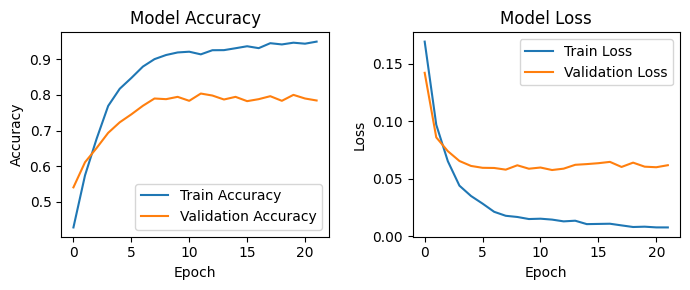

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.4195
Epoch 1: val_accuracy did not improve from 0.80370
68/68 [==============================] - 16s 168ms/step - loss: 0.1693 - accuracy: 0.4195 - val_loss: 0.1310 - val_accuracy: 0.5737
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.5863
Epoch 2: val_accuracy did not improve from 0.80370
68/68 [==============================] - 9s 128ms/step - loss: 0.0952 - accuracy: 0.5863 - val_loss: 0.0790 - val_accuracy: 0.6441
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 0.0628 - accuracy: 0.6979
Epoch 3: val_accuracy did not improve from 0.80370
68/68 [==============================] - 9s 128ms/step - loss: 0.0628 - accuracy: 0.6979 - val_loss: 0.0603 - val_accuracy: 0.6923
Epoch 4/100
68/68 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.7830
Epoch 4: val_accuracy did not improve from 0.80370
68/68 [===============

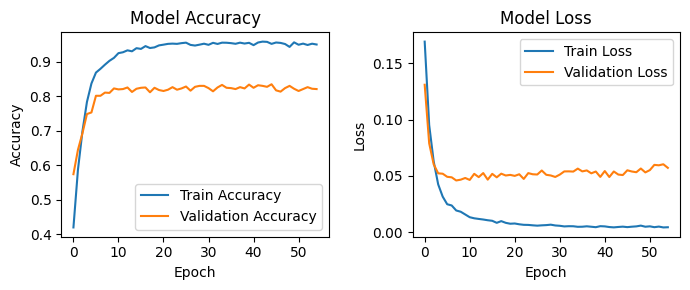

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.4218
Epoch 1: val_accuracy did not improve from 0.83411
68/68 [==============================] - 16s 148ms/step - loss: 0.1685 - accuracy: 0.4218 - val_loss: 0.1367 - val_accuracy: 0.5774
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.5921
Epoch 2: val_accuracy did not improve from 0.83411
68/68 [==============================] - 9s 128ms/step - loss: 0.0952 - accuracy: 0.5921 - val_loss: 0.0829 - val_accuracy: 0.6386
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.6940
Epoch 3: val_accuracy did not improve from 0.83411
68/68 [==============================] - 9s 129ms/step - loss: 0.0626 - accuracy: 0.6940 - val_loss: 0.0696 - val_accuracy: 0.6728
Epoch 4/100
68/68 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.7922
Epoch 4: val_accuracy did not improve from 0.83411
68/68 [===============

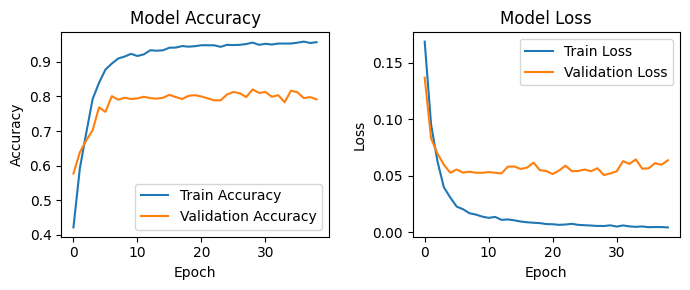

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.4149
Epoch 1: val_accuracy did not improve from 0.83411
68/68 [==============================] - 15s 148ms/step - loss: 0.1662 - accuracy: 0.4149 - val_loss: 0.1350 - val_accuracy: 0.5718
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.6027
Epoch 2: val_accuracy did not improve from 0.83411
68/68 [==============================] - 9s 128ms/step - loss: 0.0934 - accuracy: 0.6027 - val_loss: 0.0731 - val_accuracy: 0.6348
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.7007
Epoch 3: val_accuracy did not improve from 0.83411
68/68 [==============================] - 9s 128ms/step - loss: 0.0640 - accuracy: 0.7007 - val_loss: 0.0583 - val_accuracy: 0.6951
Epoch 4/100
68/68 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.7679
Epoch 4: val_accuracy did not improve from 0.83411
68/68 [===============

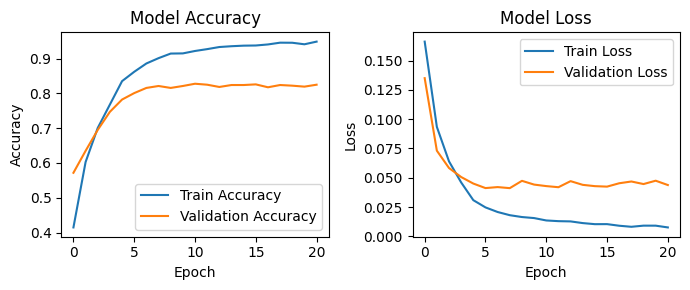

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.4160
Epoch 1: val_accuracy did not improve from 0.83411
68/68 [==============================] - 16s 161ms/step - loss: 0.1701 - accuracy: 0.4160 - val_loss: 0.1395 - val_accuracy: 0.5570
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.5791
Epoch 2: val_accuracy did not improve from 0.83411
68/68 [==============================] - 9s 129ms/step - loss: 0.0993 - accuracy: 0.5791 - val_loss: 0.0825 - val_accuracy: 0.6386
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.6822
Epoch 3: val_accuracy did not improve from 0.83411
68/68 [==============================] - 9s 129ms/step - loss: 0.0661 - accuracy: 0.6822 - val_loss: 0.0685 - val_accuracy: 0.6682
Epoch 4/100
68/68 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.7820
Epoch 4: val_accuracy did not improve from 0.83411
68/68 [===============

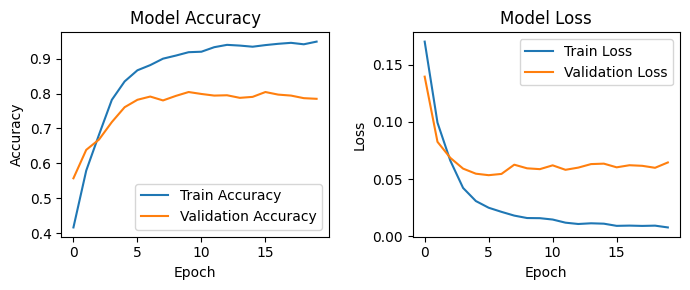

'\nbefore focal loss\nloss: 1.9258 - accuracy: 0.1355 - val_loss: 1.9560 - val_accuracy: 0.1398\nEpoch 19/50\n'

In [123]:

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("Resnet50.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,verbose=1)

from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50


train_x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3);
train_y = np.array([i[1] for i in dataset])
#splitting the dataset
x_train , x_test , y_train, y_test = train_test_split(train_x,train_y, test_size=0.2)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define variables to track the best model
best_model = None
best_score = 0.0

# Evaluate the model
scores = []
for train_index, test_index in kfold.split(train_x):
    # Get the training and testing data for this fold
    X_train, X_test = train_x[train_index], train_x[test_index]
    y_train = to_categorical(train_y[train_index], num_classes=8)
    y_test = to_categorical(train_y[test_index], num_classes=8)
    model=get_model(ResNet50)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=64,
        epochs=100,
        callbacks=[checkpoint,earlystop]

    )
    
    import matplotlib.pyplot as plt

    # Access training history
    history_dict = history.history

    # Plot training & validation accuracy values
    plt.figure(figsize=(7, 3))
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['accuracy'], label='Train Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['loss'], label='Train Loss')
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
'''
before focal loss
loss: 1.9258 - accuracy: 0.1355 - val_loss: 1.9560 - val_accuracy: 0.1398
Epoch 19/50
'''

In [124]:

loss,accuracy = model.evaluate(X_test,y_test)
#print("Accuracy:",accuracy)


34/34 [==============================] - 3s 67ms/step - loss: 0.0645 - accuracy: 0.7850


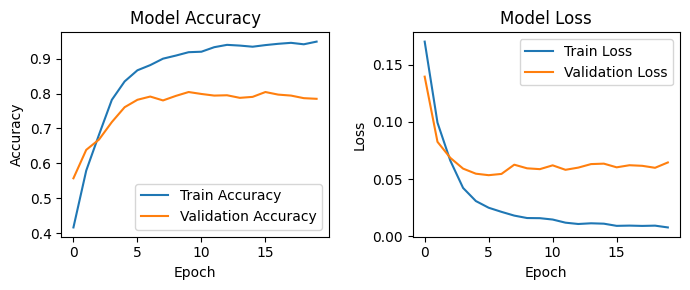

In [125]:
import matplotlib.pyplot as plt

# Access training history
history_dict = history.history

# Plot training & validation accuracy values
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [126]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)


34/34 [==============================] - 3s 49ms/step


In [127]:
report = classification_report(y_true_labels, y_pred_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.34      0.45       149
           1       0.91      0.98      0.94       107
           2       0.72      0.89      0.80       361
           3       0.79      0.73      0.76       124
           4       0.67      0.76      0.71        58
           5       0.87      0.93      0.90       104
           6       0.94      0.81      0.87       110
           7       0.94      0.73      0.82        66

    accuracy                           0.78      1079
   macro avg       0.81      0.77      0.78      1079
weighted avg       0.78      0.78      0.77      1079



In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

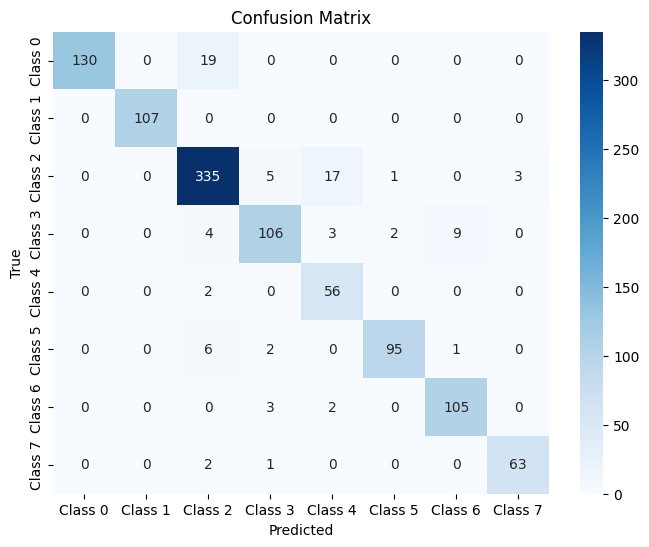

In [129]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


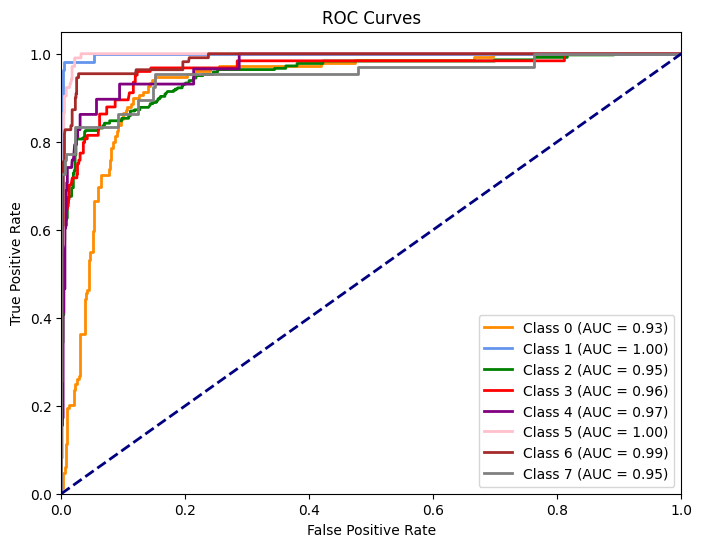

In [130]:
# Calculate ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 8  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'pink', 'brown', 'gray']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

In [131]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

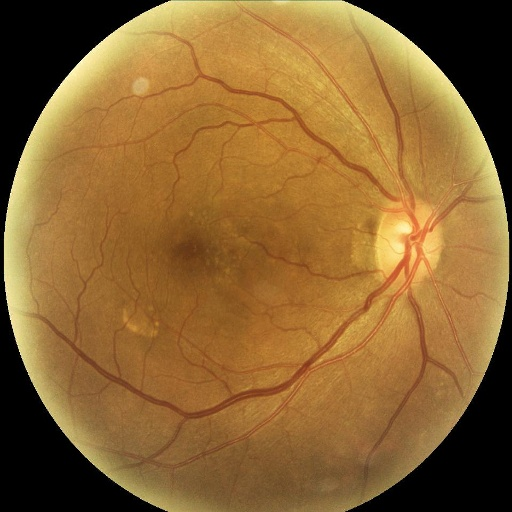

In [132]:
model_builder = keras.applications.ResNet50
img_size = (224, 224)
preprocess_input = keras.applications.resnet50.preprocess_input
decode_predictions = keras.applications.resnet50.decode_predictions

last_conv_layer_name = "conv5_block3_out"

# The local path to our target image
img_path = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1147_right.jpg"

display(Image(img_path))

In [133]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

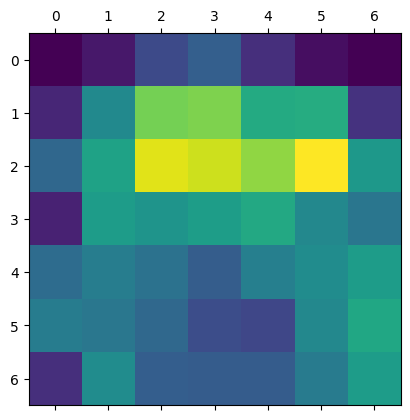

In [137]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model


model = get_model(model_builder)



# Remove last layer's softmax
model.layers[-1].activation = None

# Prepare the image
img_array = keras.applications.resnet.preprocess_input(get_img_array(img_path, size=img_size))

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display the heatmap
plt.matshow(heatmap)
plt.show()


/tmp/ipykernel_32/2437998364.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


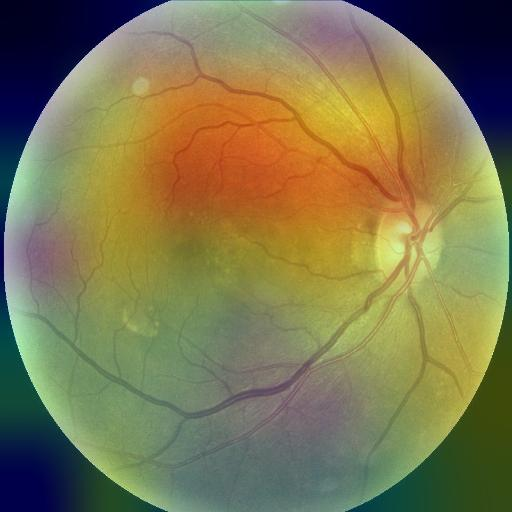

In [138]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [139]:
model.save("res.h5")

In [ ]:
#####################################################################################################################################

In [82]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [83]:
num_classes = 8

# Load the MobileNetV2 model (without the top layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [84]:
from tensorflow.keras.regularizers import l2
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)  # Add another dense layer
x = Dropout(0.5)(x)  # Add dropout
predictions = Dense(8, activation='softmax')(x)


In [85]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [86]:
# Define optimizer, loss function, and evaluation metric
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
optimizer = optimizer  # You can adjust the learning rate
#loss = 'categorical_crossentropy'
loss = lambda y_true, y_pred: focal_loss(y_true, y_pred)
metrics = ['accuracy']

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [87]:
#model.summary()

In [88]:
history = model.fit(
           X_train, y_train,
             validation_data=(X_test, y_test),
            steps_per_epoch=20,
            batch_size=64,
            epochs =100,
            validation_steps=5,
            verbose = 1,
            callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=50,
                restore_best_weights=True
            )
        ]
)


Epoch 1/100
20/20 [==============================] - 7s 160ms/step - loss: 0.6233 - accuracy: 0.1922 - val_loss: 0.5681 - val_accuracy: 0.3156
Epoch 2/100
20/20 [==============================] - 2s 91ms/step - loss: 0.5778 - accuracy: 0.2578 - val_loss: 0.5497 - val_accuracy: 0.3187
Epoch 3/100
20/20 [==============================] - 2s 108ms/step - loss: 0.5500 - accuracy: 0.3117 - val_loss: 0.5347 - val_accuracy: 0.3187
Epoch 4/100
20/20 [==============================] - 2s 90ms/step - loss: 0.5333 - accuracy: 0.3229 - val_loss: 0.5206 - val_accuracy: 0.3281
Epoch 5/100
20/20 [==============================] - 2s 109ms/step - loss: 0.5197 - accuracy: 0.3164 - val_loss: 0.5072 - val_accuracy: 0.3469
Epoch 6/100
20/20 [==============================] - 2s 111ms/step - loss: 0.5074 - accuracy: 0.3367 - val_loss: 0.4935 - val_accuracy: 0.3500
Epoch 7/100
20/20 [==============================] - 2s 105ms/step - loss: 0.4944 - accuracy: 0.3149 - val_loss: 0.4811 - val_accuracy: 0.3500
E

In [89]:
#loss,accuracy = model.evaluate(x_test,y_test_cat)
#print("Accuracy:",accuracy)
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test,y_test)



34/34 [==============================] - 1s 36ms/step - loss: 0.1904 - accuracy: 0.4588


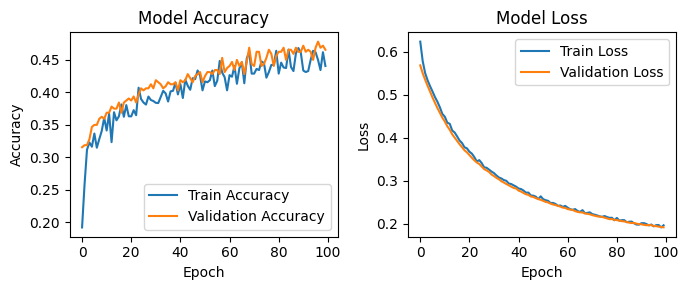

In [90]:
import matplotlib.pyplot as plt

# Access training history
history_dict = history.history

# Plot training & validation accuracy values
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()